In [1]:
import tensorflow as tf
from itertools import count as COUNTER
import sys
import matplotlib.pyplot as plt

### Definindo task

In [2]:
import numpy as np
from physics_sim import PhysicsSim

class Task():
    """Task (environment) that defines the goal and provides feedback to the agent."""
    def __init__(self, init_pose=None, init_velocities=None, 
        init_angle_velocities=None, runtime=5., target_pos=None):
        """Initialize a Task object.
        Params
        ======
            init_pose: initial position of the quadcopter in (x,y,z) dimensions and the Euler angles
            init_velocities: initial velocity of the quadcopter in (x,y,z) dimensions
            init_angle_velocities: initial radians/second for each of the three Euler angles
            runtime: time limit for each episode
            target_pos: target/goal (x,y,z) position for the agent
        """
        # Simulation
        self.sim = PhysicsSim(init_pose, init_velocities, init_angle_velocities, runtime) 
        self.action_repeat = 3

        self.state_size = self.action_repeat * 6 + 6
        self.action_low = 0
        self.action_high = 900
        self.action_size = 4

        # Goal
        self.target_pos = target_pos if target_pos is not None else np.array([0., 0., 10.]) 

    def get_reward(self):
        """Uses current pose of sim to return reward."""
        reward = 1 - 1 * np.sqrt(((self.sim.pose[:3] - self.target_pos)**2).sum())
        
        #reward += - 1 *(task.sim.pose[3:] > 3.).any()
        
        return reward
    
    def step(self, rotor_speeds):
        """Uses action to obtain next state, reward, done."""
        reward = 0
        pose_all = []
        for _ in range(self.action_repeat):
            done = self.sim.next_timestep(rotor_speeds) # update the sim pose and velocities
            reward += self.get_reward() 
            pose_all.append(self.sim.pose)
            
        pose_all_np = np.concatenate(pose_all)
        next_state = np.concatenate([pose_all_np, self.sim.v, self.sim.angular_v])
        return next_state, reward, done

    def reset(self):
        """Reset the sim to start a new episode."""
        self.sim.reset()
        state = np.concatenate([np.concatenate([self.sim.pose] * self.action_repeat), self.sim.v, self.sim.angular_v]) 
        return state

### Analisando dimensões
pode ser útil criar feature scalling 

### Inicializando as tarefas

In [3]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 500.                                     # time limit of the episode
init_pose = np.array([0., 0., 1., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])            # initial velocities
init_angle_velocities = np.array([0., 0., 0.])      # initial angle velocities
target_pos = np.array([0., 0., 200.]);

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)

In [4]:
next_state, reward, _ = task.step(1*np.array([1.1, 1., 1., 1.]))
print('Reward', reward)
print('Posição', next_state[:3])
print('Posição Angular', task.sim.pose[3:])
print('Velocidade', task.sim.v)
print('velocidade angular', task.sim.angular_v)

Reward -594.0274708330526
Posição [0.         0.         0.99803801]
Posição Angular [0.         6.28318525 0.        ]
Velocidade [-2.86867730e-12  0.00000000e+00 -5.88784354e-01]
velocidade angular [ 0.00000000e+00 -2.88303794e-06  0.00000000e+00]


# Ruído Ornstein–Uhlenbeck

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = self.mu

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

# Replay Buffer

In [6]:
import random
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## The actor ( Policy )

In [7]:
class policy_estimator():
    def __init__(self, state_size, action_low, action_high, learning_rate = 0.001, scope = 'policy'):
        with tf.variable_scope(scope):
            
            #criando placeholders
            self.state  = tf.placeholder(tf.float32, [None, state_size], 'state')
            self.action_gradients = tf.placeholder(tf.float32, name= 'target')
            
            self.fc1 = tf.contrib.layers.fully_connected(inputs= self.state
                                                        , num_outputs= 10
                                                        , activation_fn = tf.nn.relu
                                                        , weights_initializer
                                                            = tf.zeros_initializer)
            
            self.fc2 = tf.contrib.layers.fully_connected(inputs= self.fc1
                                                        , num_outputs= 5
                                                        , activation_fn = tf.nn.relu
                                                        , weights_initializer
                                                            = tf.zeros_initializer)
            
            self.fc3 = tf.contrib.layers.fully_connected(inputs= self.fc2
                                                        , num_outputs= 1
                                                        , activation_fn = tf.nn.relu
                                                        , weights_initializer
                                                            = tf.zeros_initializer)
            
            
            self.fc4 = tf.contrib.layers.fully_connected(inputs= self.fc3
                                                        , num_outputs= 4
                                                        , activation_fn = tf.nn.sigmoid
                                                        , weights_initializer
                                                            = tf.ones_initializer)
            
            self.action = 900.*tf.squeeze(self.fc4)
            
            #loss
            self.loss =  - tf.reduce_mean(self.action * self.action_gradients)
            
            #train
            self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            
    def rotor_actions(self, sess, state):
        return sess.run(self.action, {self.state: state})
    
    def update(self, sess, state, action_gradients):
        feed_dict = {self.state: state, self.action_gradients: action_gradients}
        _, loss = sess.run([self.train, self.loss], feed_dict= feed_dict) 
        return loss

# The critic (Value)

In [31]:
class value_estimator():
    def __init__(self, state_size, action_size, tau = 0.01, learning_rate = 0.001, scope = 'value_estimator'):
        
        with tf.variable_scope(scope):
            
            self.state = tf.placeholder(tf.float32, [None, state_size], name= 'state')
            self.actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
            self.target = tf.placeholder(tf.float32, name= 'target')
            self.tau = tf.placeholder(tf.float32, name= 'tau')
            
            #weights -- o treino fica mais rápido criando os placeholders
            n_outputs = 20
            self.holder_w_state_1 = tf.placeholder(tf.float32, [state_size, n_outputs])
            self.holder_w_action_1 = tf.placeholder(tf.float32, [action_size, n_outputs])
            self.holder_w_output = tf.placeholder(tf.float32, [n_outputs*2, 1])
            
            
            self.holder_b_state_1 = tf.placeholder(tf.float32, [n_outputs])
            self.holder_b_action_1 = tf.placeholder(tf.float32, [n_outputs])
            self.holder_b_output = tf.placeholder(tf.float32, [1])
            
            #states - usando relu
            self.w_state_1 = tf.Variable(dtype= tf.float32
                                        ,initial_value= tf.truncated_normal([state_size, n_outputs], stddev= 0.1)
                                        ,name= 'w_state_1')
            self.b_state_1 = tf.Variable(dtype= tf.float32
                                        ,initial_value= tf.zeros([n_outputs])
                                        , name= 'b_state_1')
            self.fc_state_1 = tf.nn.relu(tf.add(tf.matmul(self.state, self.w_state_1), self.b_state_1))
            
            
            #actions - usando relu
            self.w_action_1 = tf.Variable(dtype=tf.float32
                                          ,initial_value= tf.truncated_normal([action_size, n_outputs], stddev= 0.1)
                                          ,name= 'w_action_1')
            self.b_action_1 = tf.Variable(dtype= tf.float32
                                            ,initial_value= tf.zeros([n_outputs])
                                            ,name= 'b_action_1')
            self.fc_action_1 = tf.nn.relu(tf.add(tf.matmul(self.actions, self.w_action_1), self.b_action_1))
            
            
            #join layers
            self.merge = tf.concat([self.fc_state_1, self.fc_action_1], 1)
            
            #output
            self.w_output = tf.Variable(dtype=tf.float32
                                          ,initial_value= tf.truncated_normal([2*n_outputs, 1], stddev= 0.1)
                                          ,name= 'w_output')
            self.b_output = tf.Variable(dtype= tf.float32
                                            ,initial_value= tf.zeros([1])
                                            ,name= 'b_output')
            self.output = tf.add(tf.matmul(self.merge, self.w_output), self.b_output)
            
            #gradients
            self.gradients = tf.gradients(self.output, self.actions)
            
            #loss function
            self.loss = tf.reduce_mean(tf.squared_difference(self.output, self.target))
            
            #train
            self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            #assign values
            self.assign_1 = tf.assign(self.w_state_1, self.tau*self.w_state_1 + (1-self.tau)*self.holder_w_state_1)
            self.assign_2 = tf.assign(self.w_action_1, self.tau*self.w_action_1 + (1-self.tau)*self.holder_w_action_1)
            self.assign_3 = tf.assign(self.w_output, self.tau*self.w_output + (1-self.tau)*self.holder_w_output)
            
            self.assign_4 = tf.assign(self.b_state_1, self.tau*self.b_state_1 + (1-self.tau)*self.holder_b_state_1)
            self.assign_5 = tf.assign(self.b_action_1, self.tau*self.b_action_1 + (1-self.tau)*self.holder_b_action_1)
            self.assign_6 = tf.assign(self.b_output, self.tau*self.b_output + (1-self.tau)*self.holder_b_output)
    
    def get_gradients(self, sess, state, action):
        gradients = sess.run(self.gradients, {self.state: state, self.actions: action})
        return gradients
        
    def predict_reward(self, sess, state, actions):
        return sess.run(self.output, {self.state: state, self.actions: actions})

    def update(self, sess, state, actions, target):
        
        #salvando pesos para soft update
        #self.weights_old = np.array(sess.run(tf.trainable_variables(scope)))
        
        feed_dict = {self.state: state, self.actions: actions, self.target: target}
        _, loss = sess.run([self.train, self.loss], feed_dict= feed_dict)
        return loss    
    
    def soft_update(self, sess, weights_old, tau = .1):
        '''Uso os weights antigos e novos para atualizar a variável 
        sess: sessão criada pelo tensorflow
        tau: pondera a atualização dos weights, entre os weights antigos e novos
        '''
        
        sess.run([self.assign_1, self.assign_2, self.assign_3, self.assign_4, self.assign_5, self.assign_6]
                    ,{ self.tau : tau
                        , self.holder_w_state_1: weights_old[0]
                        , self.holder_b_state_1: weights_old[1]
                        , self.holder_w_action_1: weights_old[2]
                        , self.holder_b_action_1: weights_old[3]
                        , self.holder_w_output: weights_old[4]
                        , self.holder_b_output: weights_old[5]})
        

### Trainning

_Feature scalling_: usar feature scalling 

In [36]:
tf.reset_default_graph()
local_critic = value_estimator(task.state_size, task.action_size, tau = 0.01, learning_rate=0.001, scope= 'critic_local')
target_critic = value_estimator(task.state_size, task.action_size, tau = 0.01, learning_rate=0.001, scope = 'critic_target')

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    
    sess.run(init)
    
    aux = np.array(sess.run(tf.trainable_variables(scope='critic_local')))    
    print(aux[0][1])

    #usando tau = 0 a atualização somente utilizara os valores em aux
    target_critic.soft_update(sess, aux, 0)
    
    aux = np.array(sess.run(tf.trainable_variables(scope='critic_target')))    
    print(aux[0][1])
    


[-0.18116628  0.03636018 -0.0089874  -0.14273633 -0.05444901 -0.0170257
 -0.10640967  0.03887366  0.02076398  0.14223197 -0.05217366  0.02163329
  0.11208548 -0.0220156  -0.09219511  0.00111779 -0.06509996  0.0333392
 -0.04893035 -0.13767077]
[-0.18116628  0.03636018 -0.0089874  -0.14273633 -0.05444901 -0.0170257
 -0.10640967  0.03887366  0.02076398  0.14223197 -0.05217366  0.02163329
  0.11208548 -0.0220156  -0.09219511  0.00111779 -0.06509996  0.0333392
 -0.04893035 -0.13767077]


Episodio 14999 - steps 7[ 1.50443614 -4.18961396  1.44045672  0.54007192]
Posicao: [-3.49643809e-07 -3.50776073e-07  0.00000000e+00]
Ângulo: [4.75843932e-05 1.22364206e-05 0.00000000e+00]

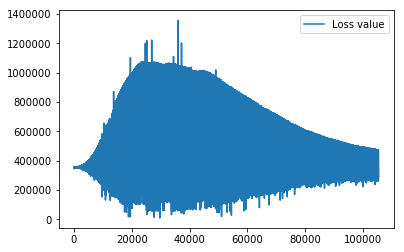

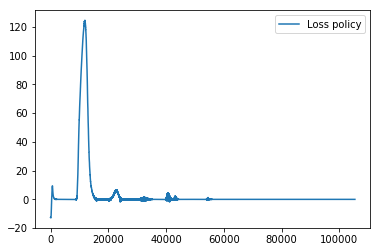

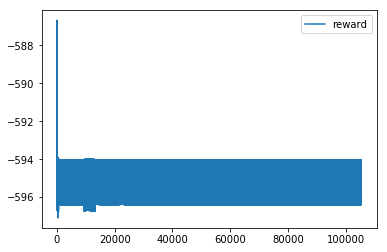

In [11]:
#Primeiro devo dar um reset no grafo                
tf.reset_default_graph()

#hiperparametros
num_episodios = 50
gamma = .99

#ruído
ruido = OUNoise(4, 0, .15, 1)

#Replay Buffer
replay = ReplayBuffer(10000, 64)

#inicializo um novo grafo aqui
policy = policy_estimator(state_size = task.state_size, action_low= 0, action_high= 900, learning_rate=0.001)
local_critic = value_estimator(task.state_size, task.action_size, tau = 0.01, learning_rate=0.001, scope= 'critic_local')
target_critic = value_estimator(task.state_size, task.action_size, tau = 0.01, learning_rate=0.001, scope = 'critic_target')

acm_reward = np.zeros(num_episodios)
loss_value = []
loss_policy = []
reward_ = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for episodio in range(num_episodios):

        #inicializando state
        state = task.reset().reshape(-1,1)
        
        for timestep in COUNTER():
            
            action = policy.rotor_actions(sess, state.reshape(1, -1)) + ruido.sample()
            next_state, reward, done = task.step(action)
            acm_reward[episodio] += reward
            
            #loop escape
            if done:
                break
            
            #salvar buffer
            replay.add(state, action, reward, next_state, done)
            
            #next action
            next_action = policy.rotor_actions(sess, next_state.reshape(1, -1))
            td_target = reward + gamma * value.predict_reward(sess
                                                              , next_state.reshape(1, -1)
                                                              , next_action.reshape(1,-1))
            
            #update value
            loss_value.append(value.update(sess, state.reshape(1, -1), action.reshape(1,-1), td_target))
            
            #soft update
            value.soft_update(sess, tau= 0.5)
        
            
            #action gradients
            action_gradients = value.get_gradients(sess, state.reshape(1, -1), action.reshape(1,-1))
            
            #update policy
            loss_policy.append(policy.update(sess, state.reshape(1, -1), action_gradients))
            
            reward_.append(reward)
            
            #update state
            state = next_state
        
        #usar buffer
        if len(replay.memory) > replay.batch_size:
            for i in replay.sample():
                
                action_next = policy.rotor_actions(sess, i.next_state.reshape(1, -1))
                td_target = i.reward \
                            + gamma * value.predict_reward(sess, i.next_state.reshape(1, -1), action_next.reshape(1,-1)) \
                            * (1 - done)
                
                #action gradients
                action_gradients = value.get_gradients(sess, i.state.reshape(1, -1), i.action.reshape(1,-1))

                #update value
                value.update(sess, i.state.reshape(1, -1), i.action.reshape(1,-1), td_target)
                
                #soft update
                value.soft_update(sess, tau= 0.1)

                #update policy
                policy.update(sess, i.state.reshape(1, -1), action_gradients)
            
        print('\rEpisodio {} - steps {}'.format(episodio, timestep), end="")    
        #print('{}'.format(task.sim.pose[:3]))
        sys.stdout.flush()
        
    print(action)        
print('\rPosicao: {}'.format(task.sim.pose[:3]), end="\n")    
print('\rÂngulo: {}'.format(task.sim.pose[3:]), end="")    

plt.plot(loss_value, label = 'Loss value')
plt.legend()
plt.show()

plt.plot(loss_policy, label = 'Loss policy')
plt.legend()
plt.show()

plt.plot(reward_, label='reward')
plt.legend()
plt.show()